In [1]:
import pandas as pd

df = pd.read_csv("urldata.csv")
df.head()

,Unnamed: 0,url,label,result
0,0,https://www.google.com,benign,0
1,1,https://www.youtube.com,benign,0
2,2,https://www.facebook.com,benign,0
3,3,https://www.baidu.com,benign,0
4,4,https://www.wikipedia.org,benign,0


In [3]:
df = df.drop(columns=['Unnamed: 0'])

df.columns

Index(['url', 'label', 'result'], dtype='object')

In [4]:
import pandas as pd
import numpy as np
import re
import math
import tldextract
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score
)


from xgboost import XGBClassifier
import lightgbm as lgb

label
benign       345738
malicious    104438
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450176 entries, 0 to 450175
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     450176 non-null  object
 1   label   450176 non-null  object
 2   result  450176 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 10.3+ MB
None


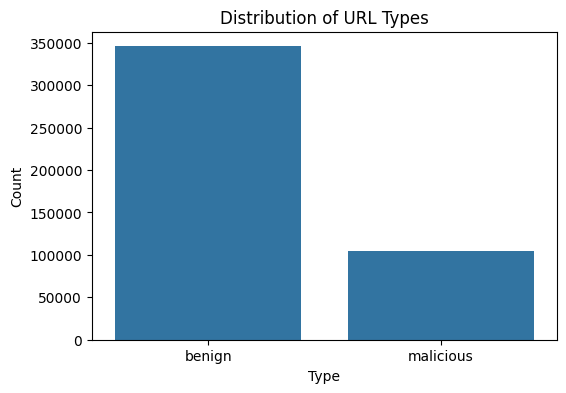

In [5]:
print(df['label'].value_counts())
print(df.info())
# ---  Distribution of URL Types ---
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.title('Distribution of URL Types')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

In [6]:
def entropy(s):
    if len(s) == 0:
        return 0
    probabilities = [s.count(c) / len(s) for c in set(s)]
    return -sum(p * math.log(p, 2) for p in probabilities)
def extract_features(url):
    ext = tldextract.extract(url)
    
    domain = ext.domain
    subdomain = ext.subdomain
    suffix = ext.suffix
    
    features = {}
    
    # Basic length features
    features["url_length"] = len(url)
    features["domain_length"] = len(domain)
    features["subdomain_length"] = len(subdomain)
    features["path_length"] = len(url.split("/")[-1])
    
    # Count features
    features["num_digits"] = sum(c.isdigit() for c in url)
    features["num_letters"] = sum(c.isalpha() for c in url)
    features["num_dots"] = url.count(".")
    features["num_hyphens"] = url.count("-")
    features["num_slashes"] = url.count("/")
    features["num_special_chars"] = sum(not c.isalnum() for c in url)
    
    # Boolean features
    features["https"] = 1 if url.startswith("https") else 0
    features["has_ip"] = 1 if re.search(r'\d+\.\d+\.\d+\.\d+', url) else 0
    
    # Suspicious keywords
    suspicious_words = ["login", "verify", "bank", "secure", "update", "free", "confirm"]
    features["sus_word_present"] = any(word in url.lower() for word in suspicious_words)
    
    # Ratios
    features["digit_ratio"] = features["num_digits"] / (features["url_length"] + 1)
    features["special_ratio"] = features["num_special_chars"] / (features["url_length"] + 1)
    
    # Entropy
    features["entropy"] = entropy(url)
    
    return features


In [12]:
df["result"]

0         0
1         0
2         0
3         0
4         0
         ..
450171    1
450172    1
450173    1
450174    1
450175    1
Name: result, Length: 450176, dtype: int64

In [ ]:
def entropy(s):
    if len(s) == 0:
        return 0
    probabilities = [s.count(c) / len(s) for c in set(s)]
    return -sum(p * math.log(p, 2) for p in probabilities)
def extract_features(url):
    ext = tldextract.extract(url)
    
    domain = ext.domain
    subdomain = ext.subdomain
    suffix = ext.suffix
    
    features = {}
    
    # Basic length features
    features["url_length"] = len(url)
    features["domain_length"] = len(domain)
    features["subdomain_length"] = len(subdomain)
    features["path_length"] = len(url.split("/")[-1])
    
    # Count features
    features["num_digits"] = sum(c.isdigit() for c in url)
    features["num_letters"] = sum(c.isalpha() for c in url)
    features["num_dots"] = url.count(".")
    features["num_hyphens"] = url.count("-")
    features["num_slashes"] = url.count("/")
    features["num_special_chars"] = sum(not c.isalnum() for c in url)
    
    # Boolean features
    features["https"] = 1 if url.startswith("https") else 0
    features["has_ip"] = 1 if re.search(r'\d+\.\d+\.\d+\.\d+', url) else 0
    
    # Suspicious keywords
    suspicious_words = ["login", "verify", "bank", "secure", "update", "free", "confirm"]
    features["sus_word_present"] = any(word in url.lower() for word in suspicious_words)
    
    # Ratios
    features["digit_ratio"] = features["num_digits"] / (features["url_length"] + 1)
    features["special_ratio"] = features["num_special_chars"] / (features["url_length"] + 1)
    
    # Entropy
    features["entropy"] = entropy(url)
    
    return features


In [15]:
#feature extraction

feature_rows = df["url"].apply(extract_features)
feature_df = pd.DataFrame(feature_rows.tolist())

final_df = pd.concat([feature_df, df[["label", "result"]]], axis=1)

final_df.head()

final_df.columns

Index(['url_length', 'domain_length', 'subdomain_length', 'path_length',
       'num_digits', 'num_letters', 'num_dots', 'num_hyphens', 'num_slashes',
       'num_special_chars', 'https', 'has_ip', 'sus_word_present',
       'digit_ratio', 'special_ratio', 'entropy', 'label', 'result'],
      dtype='object')

In [16]:
final_df.columns

Index(['url_length', 'domain_length', 'subdomain_length', 'path_length',
       'num_digits', 'num_letters', 'num_dots', 'num_hyphens', 'num_slashes',
       'num_special_chars', 'https', 'has_ip', 'sus_word_present',
       'digit_ratio', 'special_ratio', 'entropy', 'label', 'result'],
      dtype='object')

In [18]:


# Choose target column
target = "result"   # or "result" if needed

# Features = everything except target
X = final_df.drop(["label", "result"], axis=1)
y = df[target]

# -------------------------------------------------
# Train/Test Split
# -------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -------------------------------------------------
# LIGHTGBM MODEL
# -------------------------------------------------
model = lgb.LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    random_state=42
)

model.fit(X_train, y_train)

# -------------------------------------------------
# Predictions
# -------------------------------------------------
preds = model.predict(X_test)

# -------------------------------------------------
# Evaluation
# -------------------------------------------------
acc = accuracy_score(y_test, preds)
print("LightGBM Accuracy:", acc)

print("\nClassification Report:")
print(classification_report(y_test, preds))
import joblib

joblib.dump(model, "lgbm.pkl")


[LightGBM] [Info] Number of positive: 83323, number of negative: 276817
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1997
[LightGBM] [Info] Number of data points in the train set: 360140, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231363 -> initscore=-1.200632
[LightGBM] [Info] Start training from score -1.200632
LightGBM Accuracy: 0.9967457461459861

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     68921
           1       1.00      0.99      0.99     21115

    accuracy                           1.00     90036
   macro avg       1.00      0.99      1.00     90036
weighted avg       1.00      1.00      1.00     90036



['lgbm.pkl']

In [21]:
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="mlogloss"
)

xgb.fit(X_train, y_train)

xgb_preds = xgb.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_preds))
print(classification_report(y_test, xgb_preds))

cm = confusion_matrix(y_test, xgb_preds)




# xgb_proba = xgb.predict_proba(X_test)
# roc = roc_auc_score(y_test, xgb_proba, multi_class='ovr')
# print("XGBoost ROC-AUC:", roc)


import joblib


joblib.dump(xgb, "xgboost_model2.pkl")

print("Models saved successfully!")


XGBoost Accuracy: 0.9968123861566485
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     68921
           1       1.00      0.99      0.99     21115

    accuracy                           1.00     90036
   macro avg       1.00      0.99      1.00     90036
weighted avg       1.00      1.00      1.00     90036

Models saved successfully!


In [22]:


import re
import math
import tldextract
import pandas as pd
import joblib

# -------------------------------
# Load Saved Model
# -------------------------------
model = joblib.load("xgboost_model2.pkl")      # or random_forest_model.pkl


label_map = {
    0: "benign",
    1: "malicious"
}




def predict_url(url):
    df = pd.DataFrame([extract_features(url)])
    pred_id = model.predict(df)[0]
    pred_label = label_map[pred_id]     # map number → label
    return pred_label


if __name__ == "__main__":
    

    while True:
        user_url = input("Enter URL to classify (or type 'exit'): ")

        if user_url.lower() == "exit":
            break

        prediction = predict_url(user_url)
        print(f"\nResult → {prediction.upper()}")
        print("-------------------------------------\n")



Result → BENIGN
-------------------------------------


Result → MALICIOUS
-------------------------------------


Result → MALICIOUS
-------------------------------------

